In [1]:
from __future__ import print_function

import argparse
import json
import os
import re
import sys
from datetime import datetime
from importlib import import_module
from itertools import combinations
from pprint import pprint
from shutil import copyfile

import numpy as np
import pandas as pd
import scipy
from deepdiff import DeepDiff  # For Deep Difference of 2 objects
from jinja2 import Environment, FileSystemLoader

from dask import compute, delayed
import sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
sys.path.append('../experiment-impact-tracker/')

import experiment_impact_tracker
from experiment_impact_tracker.create_graph_appendix import (
    create_graphs, create_scatterplot_from_df)
from experiment_impact_tracker.data_interface import DataInterface
from experiment_impact_tracker.data_utils import (load_data_into_frame,
                                                  load_initial_info,
                                                  zip_data_and_info)
from experiment_impact_tracker.emissions.common import \
    get_realtime_carbon_source
from experiment_impact_tracker.emissions.constants import PUE
from experiment_impact_tracker.emissions.get_region_metrics import \
    get_zone_name_by_id
from experiment_impact_tracker.stats import (get_average_treatment_effect,
                                             run_test)
from experiment_impact_tracker.utils import gather_additional_info

# pd.set_option('display.max_colwidth', -1)

loading region bounding boxes for computing carbon emissions region, this may take a moment...
 454/454... rate=490.32 Hz, eta=0:00:00, total=0:00:00, wall=21:59 EST
Done!
../experiment_impact_tracker/data_interface.py:37: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option("display.max_colwidth", -1)


In [2]:
project_dir = '../../watts_up_compute/'
fastsurfer_exp_dir = '{}/FastSurfer_experiments/'.format(project_dir)
preproc_exp_dir = '{}/preproc_pipeline_experiments/'.format(project_dir)
fastsurfer_results_dir = '{}results/exp_impact_tracker/'.format(fastsurfer_exp_dir)
preproc_results_dir = '{}results/exp_impact_tracker/'.format(preproc_exp_dir)
subject_lists = '{}subject_lists/ukb_pilot_subjects.csv'.format(project_dir)

FastCNN_dir = fastsurfer_results_dir + 'ukb/FastCNN/'
FastRecon_dir = fastsurfer_results_dir + 'ukb/FastRecon/'

In [3]:
# parser = argparse.ArgumentParser(
#         description=__doc__,
#         formatter_class=argparse.RawDescriptionHelpFormatter)

# parser.add_argument('logdirs', nargs='+',
#                     help="Input directories", type=str)
# parser.add_argument('ISO3_COUNTRY_CODE')
# args = parser.parse_args(arguments)

def get_footprint(logdirs, PUE, ISO3_COUNTRY_CODE):

    data_interface = DataInterface(logdirs)

    total_power = data_interface.total_power
    kg_carbon = data_interface.kg_carbon
    # PUE = data_interface.PUE
    total_wall_clock_time = data_interface.exp_len_hours

    cscc_filepath = os.path.join(os.path.dirname(experiment_impact_tracker.__file__),
                                'emissions/data/cscc_db_v2.csv')

    ssc = pd.read_csv(cscc_filepath)

    # only use short-run model
    ssc = ssc[ssc["run"] == "bhm_sr"]
    ssc = ssc[ssc["SSP"] == "SSP2"]
    ssc = ssc[ssc["ISO3"] == ISO3_COUNTRY_CODE]
    ssc = ssc[np.isnan(ssc["dr"])] # use only growth adjusted models
    ssc = ssc[ssc["prtp"] == 2] # a growth adjusted discount rate with 2% pure rate of time preference
    ssc = ssc[ssc["eta"] == "1p5"] # IES of 1.5
    ssc = ssc[ssc["RCP"] == "rcp60"] # rcp 6, middle of the road
    ssc = ssc[ssc["dmgfuncpar"] == "bootstrap"]
    ssc = ssc[ssc["climate"] == "uncertain"] 

    median = ssc["50%"]
    lower = ssc["16.7%"]
    upper = ssc["83.3%"]

    median_carbon_cost = (kg_carbon / 1000.) * float(median)
    upper_carbon_cost = (kg_carbon / 1000.) * float(upper)
    lower_carbon_cost = (kg_carbon / 1000.) * float(lower)

    footprint = pd.DataFrame(columns = ['PUE','ISO3_COUNTRY_CODE','total_wall_clock_time','total_power','kg_carbon','carbon_cost'])
    footprint.loc[0] = [PUE, ISO3_COUNTRY_CODE,total_wall_clock_time,total_power,kg_carbon,median_carbon_cost]

    return footprint

def get_footprint_exp_set(exp_dirs, PUE, ISO3_COUNTRY_CODE):

    values = [delayed(get_footprint)(exp_dir, PUE, ISO3_COUNTRY_CODE) for exp_dir in exp_dirs]
    df_list = compute(*values, scheduler='processes', num_workers=4)

    footprint_df = pd.DataFrame()
    for exp_dir, df in zip(exp_dirs, df_list):        
        df['exp_name'] = exp_dir.rsplit('/',1)[1]
        footprint_df = footprint_df.append(df)

    return footprint_df

In [4]:
experiment_sets = {
                ## FreeSurfer baseline
                   'recon-all_run_1':(preproc_results_dir + 'ukb/run_1/', False), # log_dir, use_cuda
                
                ## FastSurferCNN run1 gpu
                   'fastsurferCNN_run1_gpu_prune_0':(FastCNN_dir + 'run_1/gpu/prune_0/', True), # log_dir, use_cuda
                
                ## FastSurferCNN run3 cpu
                   'fastsurferCNN_run3_cpu_prune_0':(FastCNN_dir + 'run_3/cpu/prune_0/', False), # log_dir, use_cuda 
                 
                ## FastSurferRecon run1 cpu
                   'fastsurferRecon_run1_cpu_prune_0':(FastRecon_dir + 'run_1/', False), # log_dir, use_cuda

                }

# PUE = 1.4 #computer canada: 1.2
PUE_list = [1,1.5,2]
ISO3_COUNTRY_CODE = 'CAN'

footprint_df = pd.DataFrame()
for exp_set, exp_set_config in experiment_sets.items():
    exp_set_dir = exp_set_config[0]
    exp_set_dirs = glob.glob(f'{exp_set_dir}/sub*')
    print(f'exp_set: {exp_set}, exp_dirs: {len(exp_set_dirs)}')

    for PUE in PUE_list:
        print(f'PUE: {PUE}')
        os.environ["OVERRIDE_PUE"] = str(PUE)

        df = get_footprint_exp_set(exp_set_dirs, PUE, ISO3_COUNTRY_CODE)
        df['exp_set'] = exp_set

        footprint_df = footprint_df.append(df)

exp_set: recon-all_run_1, exp_dirs: 73
PUE: 1
PUE: 1.5
PUE: 2
exp_set: fastsurferCNN_run1_gpu_prune_0, exp_dirs: 73
PUE: 1
PUE: 1.5
PUE: 2
exp_set: fastsurferCNN_run3_cpu_prune_0, exp_dirs: 73
PUE: 1
PUE: 1.5
PUE: 2
exp_set: fastsurferRecon_run1_cpu_prune_0, exp_dirs: 73
PUE: 1
PUE: 1.5
PUE: 2


In [7]:
# footprint_df.to_csv('/home/nikhil/projects/green_comp_neuro/watts_up_compute/PUE/ukb_pilot_run.csv')
footprint_df.shape

(876, 8)

In [8]:
# Start time 3pm

footprint_df_recon_all = footprint_df[footprint_df['exp_set']=='recon-all_run_1'].copy()
footprint_df_recon_all['exp_set'] = 'FreeSurfer'

footprint_df_fastsurfer_cpu = footprint_df[footprint_df['exp_set'].isin(['fastsurferCNN_run3_cpu_prune_0','fastsurferRecon_run1_cpu_prune_0'])].copy()
footprint_df_fastsurfer_gpu = footprint_df[footprint_df['exp_set'].isin(['fastsurferCNN_run1_gpu_prune_0','fastsurferRecon_run1_cpu_prune_0'])].copy()

print(footprint_df_recon_all.shape,footprint_df_fastsurfer_cpu.shape,footprint_df_fastsurfer_gpu.shape)

### This is sanity-checked
footprint_df_fastsurfer_cpu = footprint_df_fastsurfer_cpu.groupby(['exp_name','PUE']).sum().reset_index()
footprint_df_fastsurfer_gpu = footprint_df_fastsurfer_gpu.groupby(['exp_name','PUE']).sum().reset_index()

footprint_df_fastsurfer_cpu['exp_set'] = 'FastSurfer_cpu'
footprint_df_fastsurfer_gpu['exp_set'] = 'FastSurfer_gpu'



(219, 8) (438, 8) (438, 8)


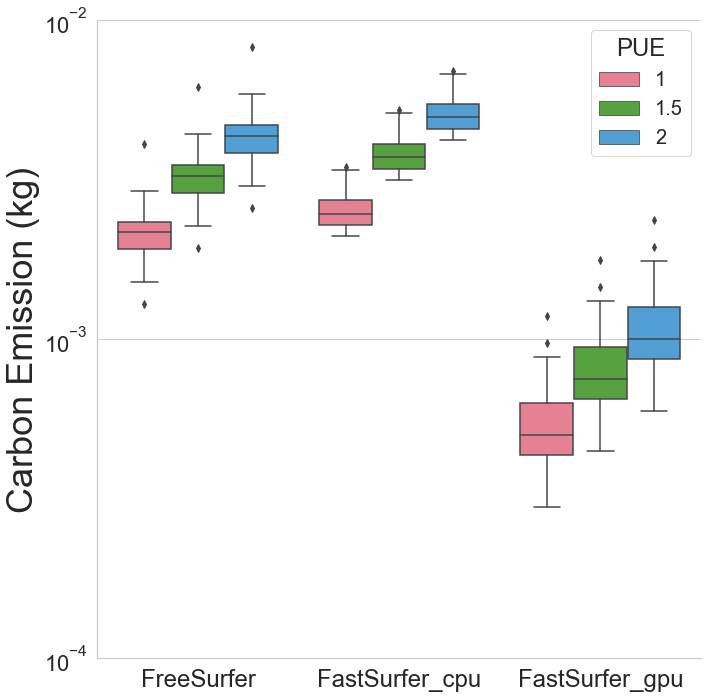

In [9]:
plot_df = footprint_df_recon_all.append(footprint_df_fastsurfer_cpu).append(footprint_df_fastsurfer_gpu).copy()

palette = sns.color_palette("husl",3)

sns.set(font_scale = 2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(10,10),sharex=False,sharey=False)
    
    g = sns.catplot(y='kg_carbon', x='exp_set', hue='PUE', data=plot_df, kind='box', palette=palette, height=10, legend=False)
    g.set_xticklabels(rotation=0,fontsize=24)
    g.ax.set_ylabel("Carbon Emission (kg)", fontsize = 36)
    g.set(xlabel = "", yscale='log', ylim=[1e-4, 1e-2]) 
    g.ax.legend(loc='upper right', fontsize=20, title='PUE')